In [125]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt

In [96]:
temporadas=["2011/2012","2012/2013","2014/2015","2015/2016"]
carpeta = "./tablas_finales/"
equipo = pd.read_csv(carpeta+"equipo_españa.csv")
liga = pd.read_csv(carpeta+"liga.csv")
partido = pd.read_csv(carpeta+"partido_españa.csv", parse_dates=["Fecha"])
plantel = pd.read_csv(carpeta+"plantel.csv")
jugador = pd.read_csv(carpeta+"jugador.csv")
atributos = pd.read_csv(carpeta+"atributos.csv", parse_dates=["Fecha"])


In [97]:
# Selecciono partidos y plantel
partido_ok = partido[partido["Temporada"].isin(temporadas)]
plantel_ok = plantel[plantel["Temporada"].isin(temporadas)]

In [98]:
# Liga española
liga = 21518

¿cuales son los jugadores que más partido ganó su equipo?

In [99]:
partido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2706 entries, 0 to 2705
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id_Partido     2706 non-null   int64         
 1   Fecha          2706 non-null   datetime64[ns]
 2   Temporada      2706 non-null   object        
 3   Id_Local       2706 non-null   int64         
 4   Id_Visitante   2706 non-null   int64         
 5   Resultado      2706 non-null   object        
 6   Id_Liga        2706 non-null   int64         
 7   Gol_local      2706 non-null   int64         
 8   Gol_visitante  2706 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 190.4+ KB


In [100]:
partidos_ganados_local = duckdb.query("""
    SELECT Id_Local as Id_Equipo
    FROM partido_ok
    WHERE Resultado = 'Ganado'
""").df()

ganados_por_locales = duckdb.query("""
    SELECT Id_Equipo, COUNT(*) AS ganados_local
    FROM partidos_ganados_local
    GROUP BY Id_Equipo
    ORDER BY ganados_local DESC;
""").df()
ganados_por_locales["Id_Equipo"].is_unique

True

In [101]:
partidos_ganados_visitante = duckdb.query("""
    SELECT Id_Visitante as Id_Equipo
    FROM partido_ok
    WHERE Resultado = 'Perdido'
""").df()

ganados_por_visitantes = duckdb.query("""
    SELECT Id_Equipo, COUNT(*) AS ganados_visitante
    FROM partidos_ganados_visitante
    GROUP BY Id_Equipo
    ORDER BY ganados_visitante DESC;
""").df()

print(partidos_ganados_visitante.head())
print(ganados_por_visitantes.head())


   Id_Equipo
0       9906
1       8634
2       8305
3       8661
4       9869
   Id_Equipo  ganados_visitante
0       8634                 52
1       8633                 50
2       9906                 34
3      10267                 24
4       8315                 20


In [102]:
ganados_por_visitantes["Id_Equipo"].is_unique

True

In [103]:
## Chequeo que los índices sean iguales en locales y visitantes para hacer la suma
## Para eso utilizo la doble inclusión.
c1 = ganados_por_locales["Id_Equipo"].isin(ganados_por_visitantes["Id_Equipo"]).all()
c2 = ganados_por_visitantes["Id_Equipo"].isin(ganados_por_locales["Id_Equipo"]).all()

print(c1 & c2)

True


In [104]:
victorias_x_equipo = duckdb.query("""
    SELECT T1.Id_Equipo as Id_Equipo, ganados_local+ganados_visitante as ganados_totales 
    FROM ganados_por_locales as T1 INNER JOIN ganados_por_visitantes as T2 
    ON T1.Id_Equipo = T2.Id_Equipo
    ORDER BY ganados_totales DESC;
""").df()
victorias_x_equipo

,Id_Equipo,ganados_totales
0,8633,114
1,8634,114
2,9906,87
3,10267,69
4,8302,64
5,9864,58
6,8560,53
7,8315,53
8,8558,45
9,8581,44


In [105]:

duckdb.query("""
    SELECT Id_Equipo
    FROM victorias_x_equipo 
    WHERE ganados_totales = (SELECT MAX(ganados_totales) FROM victorias_x_equipo);
""")
# print(res)

┌───────────┐
│ Id_Equipo │
│   int64   │
├───────────┤
│      8633 │
│      8634 │
└───────────┘

¿Cual es el jugador con menor variación de potencia a lo largo de los años?

Analizo desde el 1° de Enero del 2011 al 31 de Diciembre del 2015

¿Qué busco cómo variación?

Por cada jugador obtengo el mínimo, y el máximo. Al máximo le resto el mínimo. Ahí tengo la variación a lo largo de los años 2011-2015

descarto jugadores que no hayan estado en las 4 temporadas

In [106]:
plantel_ok

,Id_Jugador,Id_Equipo,Temporada
0,95597,4087,2011/2012
1,38805,4087,2011/2012
2,35560,4087,2011/2012
3,210691,4087,2011/2012
4,93343,4087,2011/2012
...,...,...,...
19570,415113,208931,2015/2016
19571,105535,208931,2015/2016
19572,128803,208931,2015/2016
19573,24123,208931,2015/2016


In [107]:
plantel_ok.info()
jugadores_todas_temporadas = duckdb.query("""
    SELECT Id_Jugador
    FROM plantel_ok
    WHERE Temporada IN ('2011/2012', '2012/2013', '2013/2014', '2014/2015')
    GROUP BY Id_Jugador
    HAVING COUNT(DISTINCT Temporada) = 3;             
""")

potencial_ok = duckdb.query("""
    SELECT T1.Id_Jugador, Potencial, Fecha
    FROM jugadores_todas_temporadas as T1 LEFT JOIN atributos as T2
    ON T1.Id_Jugador = T2.Id_Jugador
""")

potencial_ok

<class 'pandas.core.frame.DataFrame'>
Index: 10847 entries, 0 to 19574
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id_Jugador  10847 non-null  int64 
 1   Id_Equipo   10847 non-null  int64 
 2   Temporada   10847 non-null  object
dtypes: int64(2), object(1)
memory usage: 339.0+ KB


┌────────────┬───────────┬─────────────────────┐
│ Id_Jugador │ Potencial │        Fecha        │
│   int64    │  double   │    timestamp_ns     │
├────────────┼───────────┼─────────────────────┤
│      27671 │      77.0 │ 2014-11-28 00:00:00 │
│      27671 │      77.0 │ 2014-09-18 00:00:00 │
│      27671 │      80.0 │ 2014-04-25 00:00:00 │
│      27671 │      82.0 │ 2014-01-17 00:00:00 │
│      27671 │      83.0 │ 2013-12-20 00:00:00 │
│      27671 │      83.0 │ 2013-11-01 00:00:00 │
│      27671 │      83.0 │ 2013-10-18 00:00:00 │
│      27671 │      83.0 │ 2013-10-11 00:00:00 │
│      27671 │      83.0 │ 2013-09-27 00:00:00 │
│      27671 │      81.0 │ 2013-09-20 00:00:00 │
│        ·   │        ·  │          ·          │
│        ·   │        ·  │          ·          │
│        ·   │        ·  │          ·          │
│      35989 │      84.0 │ 2009-02-22 00:00:00 │
│      35989 │      84.0 │ 2008-08-30 00:00:00 │
│      35989 │      84.0 │ 2007-08-30 00:00:00 │
│      35989 │      

Observación, hay jugadores 

In [109]:
res_raw = duckdb.query("""
    SELECT Id_Jugador, STDDEV(Potencial) AS Variacion_Potencial 
    FROM potencial_ok
    GROUP BY Id_Jugador
    ORDER BY Variacion_Potencial
    DESC;
""" ).df()
Jugador_Variacion_Potencial = duckdb.query("""
    SELECT * FROM res_raw WHERE Variacion_Potencial IS NOT NULL
""").df()

Jugador_Mayor_Variacion = duckdb.query("""
    SELECT * FROM Jugador_Variacion_Potencial
    WHERE Variacion_Potencial = (SELECT MAX(Variacion_Potencial) FROM Jugador_Variacion_Potencial)
""")

Jugador_Menor_Variacion = duckdb.query("""
    SELECT * FROM Jugador_Variacion_Potencial
    WHERE Variacion_Potencial = (SELECT MIN(Variacion_Potencial) FROM Jugador_Variacion_Potencial)
""")
print(Jugador_Mayor_Variacion)
print(Jugador_Menor_Variacion)

┌────────────┬─────────────────────┐
│ Id_Jugador │ Variacion_Potencial │
│   int64    │       double        │
├────────────┼─────────────────────┤
│      93457 │  10.998663020353616 │
└────────────┴─────────────────────┘

┌────────────┬─────────────────────┐
│ Id_Jugador │ Variacion_Potencial │
│   int64    │       double        │
├────────────┼─────────────────────┤
│     192316 │  0.5737304826019519 │
└────────────┴─────────────────────┘



In [110]:
Nombre_Menor_Variacion = duckdb.query("""
    SELECT Nombre FROM Jugador_Menor_Variacion as T1 INNER JOIN jugador as T2 on T1.Id_Jugador = T2.Id_Jugador
""")
Nombre_Mayor_Variacion = duckdb.query("""
    SELECT Nombre FROM Jugador_Mayor_Variacion as T1 INNER JOIN jugador as T2 on T1.Id_Jugador = T2.Id_Jugador
""")
print(Nombre_Menor_Variacion)
print(Nombre_Mayor_Variacion)

┌────────────────┐
│     Nombre     │
│    varchar     │
├────────────────┤
│ Mattias Autret │
└────────────────┘

┌─────────────┐
│   Nombre    │
│   varchar   │
├─────────────┤
│ Lamine Kone │
└─────────────┘



Graficar el promedio de gol de los equipos a lo largo de los años que elijan

In [116]:
partido_ok = duckdb.query("""
    SELECT * 
    FROM partido
    WHERE Temporada IN ('2011/2012', '2012/2013', '2013/2014', '2014/2015')
""")
# print(partido_ok)

goles_local = duckdb.query("""
    SELECT Id_Local as Id_Equipo, Gol_local, Fecha, Temporada FROM partido_ok
""")

local_x_temporada = duckdb.query("""
    SELECT Id_Equipo, SUM(Gol_local) as Gol_local, temporada
    FROM goles_local
    GROUP BY Id_Equipo, Temporada
""")

goles_visitante = duckdb.query("""
    SELECT Id_Visitante as Id_Equipo, Gol_visitante, Id_Partido, Fecha, Temporada FROM partido_ok
""")

visitante_x_temporada = duckdb.query("""
    SELECT Id_Equipo, SUM(Gol_visitante) as Gol_visitante, temporada
    FROM goles_visitante 
    GROUP BY Id_Equipo, Temporada
""")

goles_x_temporada = duckdb.query("""
    SELECT T1.Id_Equipo, (T2.Gol_visitante + T1.Gol_local) as Gol, T1.Temporada
    FROM local_x_temporada as T1 INNER JOIN visitante_x_temporada as T2
    ON T1.Id_Equipo = T2.Id_Equipo AND T1.Temporada = T2.Temporada
""")
goles_x_temporada

┌───────────┬────────┬───────────┐
│ Id_Equipo │  Gol   │ Temporada │
│   int64   │ int128 │  varchar  │
├───────────┼────────┼───────────┤
│      8603 │     47 │ 2011/2012 │
│      8696 │     28 │ 2011/2012 │
│      8302 │     58 │ 2012/2013 │
│      9910 │     49 │ 2013/2014 │
│      9864 │     35 │ 2013/2014 │
│      7878 │     29 │ 2014/2015 │
│      8305 │     31 │ 2014/2015 │
│      8558 │     46 │ 2011/2012 │
│      8634 │    112 │ 2012/2013 │
│      8581 │     39 │ 2012/2013 │
│        ·  │      · │     ·     │
│        ·  │      · │     ·     │
│        ·  │      · │     ·     │
│      9910 │     44 │ 2014/2015 │
│      7869 │     21 │ 2014/2015 │
│      9864 │     54 │ 2011/2012 │
│      8394 │     35 │ 2011/2012 │
│      8371 │     33 │ 2012/2013 │
│      8603 │     36 │ 2013/2014 │
│      8581 │     34 │ 2014/2015 │
│      8634 │    104 │ 2014/2015 │
│      8560 │     40 │ 2014/2015 │
│      9906 │     64 │ 2014/2015 │
├───────────┴────────┴───────────┤
│ 80 rows (20 shown)

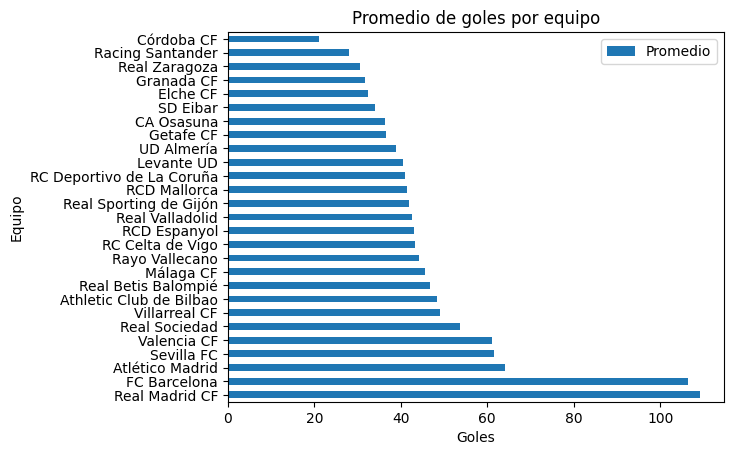

In [127]:
promedio = duckdb.query("""
    SELECT Id_Equipo, MEAN(Gol) as Promedio
    FROM goles_x_temporada
    GROUP BY Id_Equipo
""")

nombres = duckdb.query("""
    SELECT Nombre, Promedio
    FROM promedio as T1 INNER JOIN equipo as T2 ON T1.Id_Equipo = T2.Id_Equipo
    ORDER BY Promedio DESC
""").df()

# x = nombres["Nombre"]
# y = nombres["Promedio"]

fig, ax = plt.subplots()
       
nombres.plot(x='Nombre', 
                    y=['Promedio'], 
                    kind='barh',
                    label=['Promedio'],   # Agrega etiquetas a la serie
                    ax = ax)
ax.set_title('Promedio de goles por equipo')
ax.set_xlabel('Goles')
ax.set_ylabel('Equipo')

fig.savefig(carpeta+'goles_convertidos.pdf', bbox_inches='tight', pad_inches=0.1)

# Graficar el número de goles convertidos por cada equipo en función de la suma de todos sus atributos.


In [128]:
partido_ok = duckdb.query("""
    SELECT * 
    FROM partido
    WHERE Temporada IN ('2011/2012', '2012/2013', '2013/2014', '2014/2015')
""")
# print(partido_ok)

goles_local = duckdb.query("""
    SELECT Id_Local as Id_Equipo, Gol_local, Fecha, Temporada FROM partido_ok
""")

local_x_equipo = duckdb.query("""
    SELECT Id_Equipo, SUM(Gol_local) as Gol_local
    FROM goles_local
    GROUP BY Id_Equipo
""")

goles_visitante = duckdb.query("""
    SELECT Id_Visitante as Id_Equipo, Gol_visitante, Id_Partido, Fecha, Temporada FROM partido_ok
""")

visitante_x_equipo = duckdb.query("""
    SELECT Id_Equipo, SUM(Gol_visitante) as Gol_visitante
    FROM goles_visitante 
    GROUP BY Id_Equipo
""")

goles_x_equipo = duckdb.query("""
    SELECT T1.Id_Equipo, (T2.Gol_visitante + T1.Gol_local) as Gol
    FROM local_x_equipo as T1 INNER JOIN visitante_x_equipo as T2
    ON T1.Id_Equipo = T2.Id_Equipo
""")

goles_x_equipo

┌───────────┬────────┐
│ Id_Equipo │  Gol   │
│   int64   │ int128 │
├───────────┼────────┤
│     10268 │     65 │
│      9864 │    182 │
│      8370 │    177 │
│      9869 │     42 │
│      8633 │    437 │
│      8696 │     28 │
│      8581 │    162 │
│      8315 │    194 │
│      8394 │     61 │
│      8372 │     34 │
│        ·  │      · │
│        ·  │      · │
│        ·  │      · │
│      8560 │    215 │
│      8558 │    172 │
│      9906 │    256 │
│     10267 │    244 │
│      7869 │     21 │
│      9865 │     78 │
│      8661 │     83 │
│      8634 │    426 │
│     10281 │     85 │
│      8371 │    109 │
├───────────┴────────┤
│ 27 rows (20 shown) │
└────────────────────┘

In [164]:
# suma de atributos constantes
Atributos_Constantes = duckdb.query("""
    SELECT Id_Jugador, Altura+Peso as Constantes
    FROM jugador
""")

Atributos_Variables = duckdb.query("""
    SELECT Id_Jugador, SUM(Potencial) + SUM(Velocidad) as Variables FROM atributos
    GROUP BY Id_Jugador
""")

Suma_Atributos_Jugadores = duckdb.query("""
    SELECT T1.Id_Jugador, (Constantes + Variables) as Atributos
    FROM Atributos_Constantes as T1 INNER JOIN Atributos_Variables as T2
    ON T1.Id_Jugador = T2.Id_Jugador
""")

Suma_Atributos_Equipos = duckdb.query("""
    SELECT E.Id_Equipo, SUM(A.Atributos) AS Atributos_Suma
    FROM Suma_Atributos as A
    INNER JOIN plantel_ok as P ON A.Id_Jugador = P.Id_Jugador
    INNER JOIN equipo as E ON P.Id_Equipo = E.Id_Equipo
    GROUP BY E.Id_Equipo;
""").df()

atributos_x_goles = duckdb.query(""" 
    Select T1.Id_Equipo, Atributos_Suma, Gol
    FROM Suma_Atributos_Equipos as T1 INNER JOIN goles_x_equipo as T2
    ON T1.Id_Equipo = T2.Id_Equipo
""").df()

atributos_x_goles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id_Equipo       27 non-null     int64  
 1   Atributos_Suma  27 non-null     float64
 2   Gol             27 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 780.0 bytes


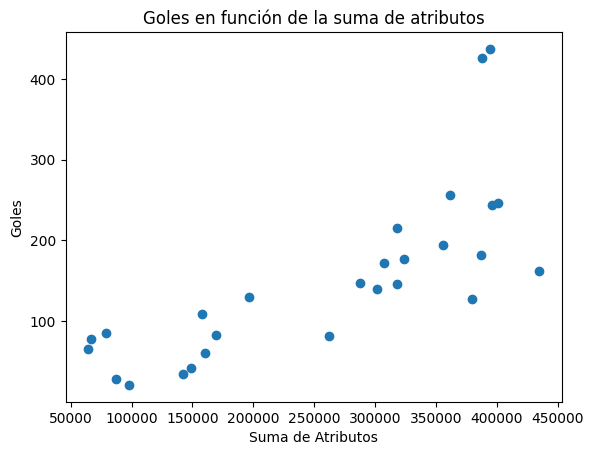

In [168]:
fig, ax = plt.subplots()

x = atributos_x_goles["Atributos_Suma"]
y = atributos_x_goles["Gol"]

plt.scatter(x,y)
       
ax.set_title('Goles en función de la suma de atributos')
ax.set_xlabel('Suma de Atributos')
ax.set_ylabel('Goles')

fig.savefig(carpeta+'goles_convertidos.pdf', bbox_inches='tight', pad_inches=0.1)
